In [1]:
#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# NLP Libraries
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load Dataset

df = pd.read_csv("climate_nasa (1).csv")
print(df.head())
print(df.info())

                       date  likesCount  \
0  2022-09-07T17:12:32.000Z           2   
1  2022-09-08T14:51:13.000Z           0   
2  2022-09-07T17:19:41.000Z           1   
3  2022-09-08T00:51:30.000Z           4   
4  2022-09-07T19:06:20.000Z          16   

                                         profileName  commentsCount  \
0  4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...            NaN   
1  518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...            NaN   
2  d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...            3.0   
3  37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...            NaN   
4  e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...           26.0   

                                                text  
0  Neat comparison I have not heard it before.\n ...  
1  An excellent way to visualise the invisible! T...  
2  Does the CO2/ghg in the troposphere affect the...  
3  excellent post! I defo feel the difference - o...  
4  Yes, and carbon dioxide does not har

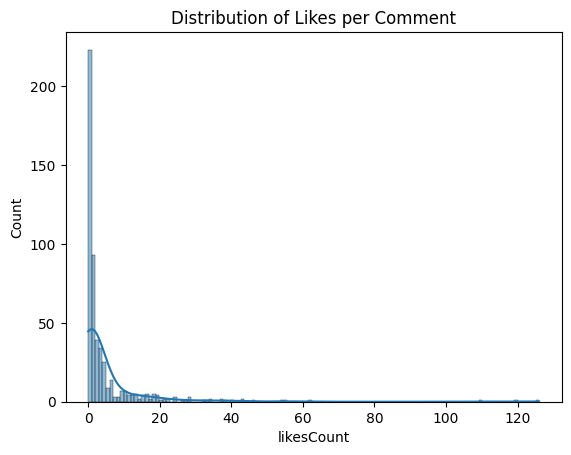

In [3]:
# 3. Exploratory Data Analysis (EDA)

# Likes & Comments Distribution
sns.histplot(df['likesCount'], kde=True)
plt.title("Distribution of Likes per Comment")
plt.show()

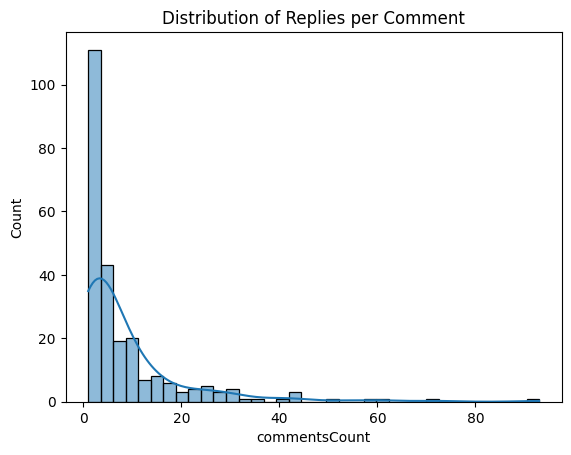

In [4]:
sns.histplot(df['commentsCount'], kde=True)
plt.title("Distribution of Replies per Comment")
plt.show()

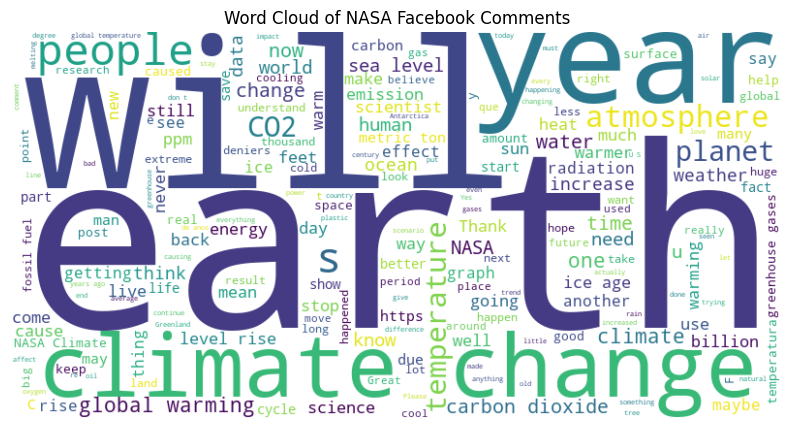

In [5]:
# WordCloud
text = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of NASA Facebook Comments')
plt.show()

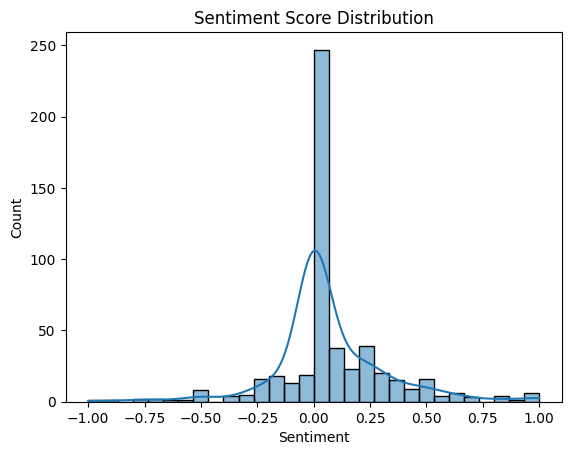

In [6]:
# Sentiment Analysis
def get_sentiment(text):
    if pd.isna(text):
        return 0
    return TextBlob(text).sentiment.polarity

df['Sentiment'] = df['text'].apply(get_sentiment)

sns.histplot(df['Sentiment'], bins=30, kde=True)
plt.title("Sentiment Score Distribution")
plt.show()

In [7]:
# 4. Feature Engineering

df['Date'] = pd.to_datetime(df['date'], errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['TextLength'] = df['text'].apply(lambda x: len(str(x)))

# Drop profile name (anonymized)
df = df.drop(columns=["profileName"])

# Drop nulls for modeling
df = df.dropna(subset=["likesCount", "commentsCount", "Sentiment"])

MAE: 7.741020408163266
MSE: 247.16208775510205
R2 Score: 0.29880900185035064


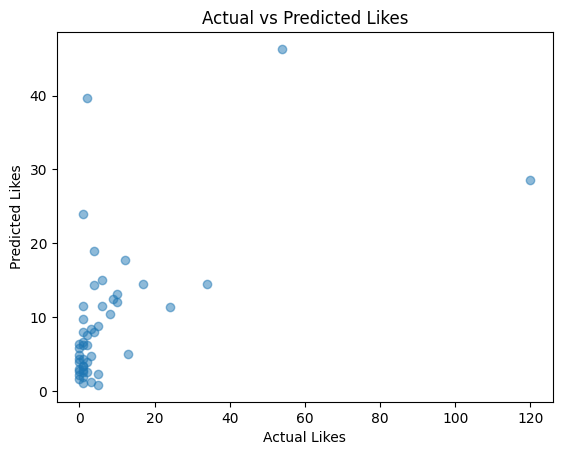

['scaler.pkl']

In [8]:
# 5. Modeling (Predicting Likes)

features = ['commentsCount', 'Sentiment', 'TextLength', 'Year', 'Month', 'Hour']
X = df[features]
y = df['likesCount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model.predict(X_test_scaled)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# Plot Actual vs Predicted
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Likes")
plt.ylabel("Predicted Likes")
plt.title("Actual vs Predicted Likes")
plt.show()

joblib.dump(model, "rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")

In [9]:
# 6. Scenario Analysis

sample = pd.DataFrame({
    'commentsCount': [5],
    'Sentiment': [0.5],
    'TextLength': [150],
    'Year': [2023],
    'Month': [5],
    'Hour': [12]
})

sample_scaled = scaler.transform(sample)
future_like_prediction = model.predict(sample_scaled)
print("Predicted Likes for sample scenario:", future_like_prediction[0])

Predicted Likes for sample scenario: 11.93


In [10]:

# Final Report 

print("\n CLIMATE CHANGE MODELING FINAL REPORT\n")

# Basic Dataset Info
print(" Dataset Summary:")
print(f"- Total Records: {df.shape[0]}")
print(f"- Columns Used: CommentsCount, Sentiment, TextLength, Year, Month, Hour")
print(f"- Target Variable: LikesCount\n")

# Model Performance
print(" Model Performance:")
print(f"  - Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.2f}")
print(f"  - Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.2f}")
print(f"  - R² Score: {r2_score(y_test, y_pred):.2f}\n")

# Important Features
print(" Feature Importance:")
importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).round(4))
print()

# Sample Scenario Prediction
print(" Sample Scenario:")
sample_input = pd.DataFrame({
    "commentsCount": [3],
    "Sentiment": [0.4],
    "TextLength": [180],
    "Year": [2023],
    "Month": [6],
    "Hour": [15]
})

scaled_sample = scaler.transform(sample_input)
sample_prediction = model.predict(scaled_sample)[0]
print(f"Predicted Likes for Sample Input: {int(sample_prediction)}\n")

# Future Work
print(" Future Enhancements:")
print("- Improve sentiment analysis with deep NLP models like BERT.")
print("- Combine comment data with actual climate data (temperature, CO2).")
print("- Expand to multilingual comment analysis.")
print("- Add location and time-based modeling for engagement.\n")

# Ethics
print(" Ethical Notes:")
print("- Usernames anonymized.")
print("- Respect public sentiment diversity.\n")


 CLIMATE CHANGE MODELING FINAL REPORT

 Dataset Summary:
- Total Records: 244
- Columns Used: CommentsCount, Sentiment, TextLength, Year, Month, Hour
- Target Variable: LikesCount

 Model Performance:
  - Mean Absolute Error (MAE): 7.74
  - Mean Squared Error (MSE): 247.16
  - R² Score: 0.30

 Feature Importance:
commentsCount    0.2959
TextLength       0.2495
Sentiment        0.2037
Hour             0.1715
Year             0.0511
Month            0.0282
dtype: float64

 Sample Scenario:
Predicted Likes for Sample Input: 18

 Future Enhancements:
- Improve sentiment analysis with deep NLP models like BERT.
- Combine comment data with actual climate data (temperature, CO2).
- Expand to multilingual comment analysis.
- Add location and time-based modeling for engagement.

 Ethical Notes:
- Usernames anonymized.
- Respect public sentiment diversity.

